In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
import hvplot.pandas

In [24]:
# Set the random seed for reproducibility
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [25]:
# Read APPL.csv contains open, high, low, close, Adj close, Volume of Apple stock with twitter polarity scores and twitter volume
stocks = pd.read_csv('AAPL.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)

stocks["Pct_change"] = stocks["Adj Close"].pct_change()

features = stocks[["Adj Close", "ts_polarity", "twitter_volume"]]
target = stocks['Pct_change']

stocks = stocks[["Adj Close", "ts_polarity", "twitter_volume", 'Pct_change']]

# Drop null values
stocks.dropna(inplace=True)
stocks.tail()

C:\Users\TEO\AppData\Local\Temp\ipykernel_22016\3088017844.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  stocks = pd.read_csv('AAPL.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)


,Adj Close,ts_polarity,twitter_volume,Pct_change
Date,,,,
2019-08-26,51.12,0.072340,888.0,0.019139
2019-08-27,50.54,0.117541,962.0,-0.011346
2019-08-28,50.88,0.061477,895.0,0.006727
2019-08-29,51.74,0.056460,1083.0,0.016903
2019-08-30,51.67,0.106096,1005.0,-0.001353


In [26]:
# THIS IS NEVER USED!
scaler = MinMaxScaler()
feature_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

In [27]:
# A mixture from https://github.com/you915/Sentiment-Analysis-of-Twitter-Data-for-predicting-Apple-stock-price and https://github.com/thomasjv799/Stock-Market-Prediction-using-LSTM-and-tweets/blob/main/lstm_tweet.ipynb
# This function "window_data" accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_columns, target_column):
    X = []
    y = []
    for i in range(len(df) - window):
        # Extract features and target from the dataframe, and append them to the lists
        features = df.iloc[i:(i + window), feature_columns].values
        target = df.iloc[i + window, target_column]
        X.append(features)
        y.append(target)
        
    return np.array(X), np.array(y).reshape(-1, 1)

# Example usage:
# Assuming 'stocks' is your dataframe and the feature and target columns are specified by indices
feature_col_indices = [stocks.columns.get_loc(col) for col in ['Adj Close', 'ts_polarity', 'twitter_volume']]
target_col_index = stocks.columns.get_loc('Pct_change')

window_size = 10  # Define your window size
X, y = window_data(stocks, window_size, feature_col_indices, target_col_index)

In [28]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [29]:
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 3))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 3))

In [30]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window_size, 3)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 50)            10800     
                                                                 
 dropout_6 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [36]:
history = model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=1, validation_split=0.1)

Epoch 1/10
131/131 [==============================] - 1s 5ms/step - loss: 3.5852e-04 - val_loss: 5.8277e-04
Epoch 2/10
131/131 [==============================] - 1s 5ms/step - loss: 2.8340e-04 - val_loss: 5.1867e-04
Epoch 3/10
131/131 [==============================] - 1s 5ms/step - loss: 2.4635e-04 - val_loss: 5.8812e-04
Epoch 4/10
131/131 [==============================] - 1s 5ms/step - loss: 2.6963e-04 - val_loss: 5.1622e-04
Epoch 5/10
131/131 [==============================] - 1s 5ms/step - loss: 2.4353e-04 - val_loss: 5.1441e-04
Epoch 6/10
131/131 [==============================] - 1s 5ms/step - loss: 2.0556e-04 - val_loss: 5.3611e-04
Epoch 7/10
131/131 [==============================] - 1s 5ms/step - loss: 2.5102e-04 - val_loss: 5.2754e-04
Epoch 8/10
131/131 [==============================] - 1s 5ms/step - loss: 2.1757e-04 - val_loss: 4.9982e-04
Epoch 9/10
131/131 [==============================] - 1s 5ms/step - loss: 2.2055e-04 - val_loss: 4.8011e-04
Epoch 10/10
131/131 [=======

In [37]:
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

6/6 [==============================] - 0s 3ms/step
Root Mean Squared Error: 0.019479913320564136
R-squared: -0.038468333995592685


In [38]:
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

results = pd.DataFrame({
    'Real': real_prices.ravel(),
    'Predicted': predicted_prices.ravel()
})

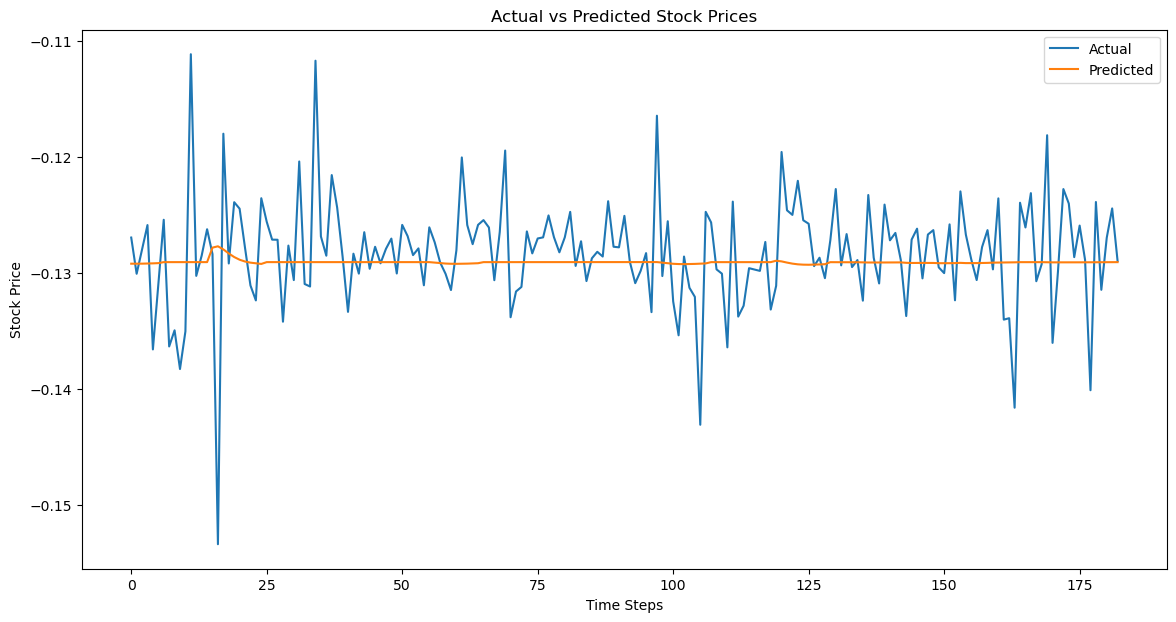

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(results['Real'], label='Actual')
plt.plot(results['Predicted'], label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

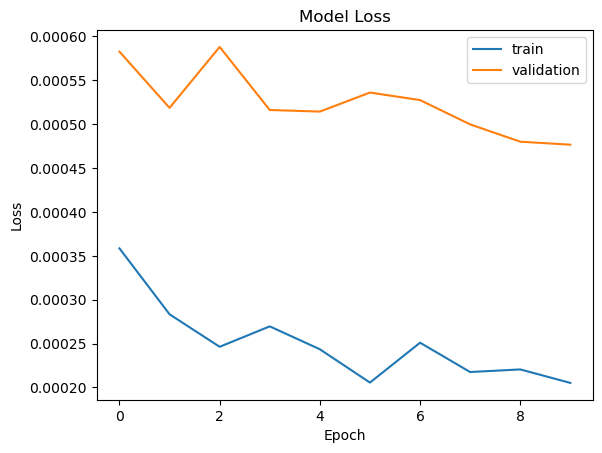

In [40]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()